In [7]:
# the following block was taken from tutorial 2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

import torch
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import warnings
from scipy.integrate import odeint
from matplotlib import style
import torch.nn as nn
from sklearn.model_selection import KFold

warnings.filterwarnings('ignore')

np.random.seed(67)

# CUDA support
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [8]:
cls = pd.read_pickle("A2Q1_data.pkl")

X_train_cls = torch.tensor(cls["X_train"].astype(float).values).float().to(device)
X_test_cls  = torch.tensor(cls["X_test"].astype(float).values).float().to(device)

y_train_cls = torch.tensor(cls["y_train"].values).float().to(device).reshape(-1, 1)
y_test_cls  = torch.tensor(cls["y_test"].values).float().to(device).reshape(-1, 1)

reg = pd.read_pickle("A2Q1_data_regression.pkl")

X_train_reg = torch.tensor(reg["X_train"].astype(float).values).float().to(device)
X_test_reg  = torch.tensor(reg["X_test"].astype(float).values).float().to(device)

y_train_reg = torch.tensor(reg["y_train"].values).float().to(device).reshape(-1, 1)
y_test_reg  = torch.tensor(reg["y_test"].values).float().to(device).reshape(-1, 1)

### Q1.1

In [9]:

def classification_metrics_from_probs(probs: torch.Tensor, y_true: torch.Tensor, threshold: float = 0.5):
    preds = (probs >= threshold).float()

    tp = ((preds == 1) & (y_true == 1)).sum().item()
    tn = ((preds == 0) & (y_true == 0)).sum().item()
    fp = ((preds == 1) & (y_true == 0)).sum().item()
    fn = ((preds == 0) & (y_true == 1)).sum().item()

    n = y_true.numel()
    acc = (tp + tn) / n if n > 0 else float("nan")
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    return acc, prec, rec

def mse_metric(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    return torch.mean((y_pred - y_true) ** 2).item()


class DNN(torch.nn.Module):
    def __init__(self, layers, min_val, max_val):
        super(DNN, self).__init__()

        self.depth = len(layers) - 1

        self.min_val = torch.tensor(min_val, requires_grad=False).float().to(device)
        self.max_val = torch.tensor(max_val, requires_grad=False).float().to(device)

        self.activation = torch.nn.Tanh

        layer_list = []
        for i in range(self.depth - 1):
            layer_list.append(("layer_%d" % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(("activation_%d" % i, self.activation()))
        layer_list.append(("layer_%d" % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1])))

        self.layers = torch.nn.Sequential(OrderedDict(layer_list))

    def forward(self, x):
        res = (x - self.min_val) / (self.max_val - self.min_val + 1e-12) # added 1e-12 cuz i kept getting error div 0
        return self.layers(res)


class DefaultClassifierNN:
    def __init__(self, X_train, y_train, layers):
        self.X_train = X_train
        self.y_train = y_train

        Xmin = X_train.min(dim=0, keepdim=True).values
        Xmax = X_train.max(dim=0, keepdim=True).values

        self.dnn = DNN(layers, Xmin, Xmax).to(device)

        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.sigmoid = torch.nn.Sigmoid()
        self.criterion = torch.nn.BCELoss()

    def forward_probs(self, X):
        logits = self.dnn(X)
        return self.sigmoid(logits)

    def train(self, adam_epochs=500):
        self.dnn.train()
        for _ in range(adam_epochs):
            probs = self.forward_probs(self.X_train)
            loss = self.criterion(probs, self.y_train)

            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()

    def predict_probs(self, X):
        self.dnn.eval()
        with torch.no_grad():
            return self.forward_probs(X)

class DefaultRegressorNN:
    def __init__(self, X_train, y_train, layers):
        self.X_train = X_train
        self.y_train = y_train

        Xmin = X_train.min(dim=0, keepdim=True).values
        Xmax = X_train.max(dim=0, keepdim=True).values

        self.dnn = DNN(layers, Xmin, Xmax).to(device)

        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.criterion = torch.nn.MSELoss()

    def train(self, adam_epochs=500):
        self.dnn.train()
        for _ in range(adam_epochs):
            pred = self.dnn(self.X_train)
            loss = self.criterion(pred, self.y_train)

            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()

    def predict(self, X):
        self.dnn.eval()
        with torch.no_grad():
            return self.dnn(X)


def report_classifier_q11(X_train, y_train, X_test, y_test, layers, epochs=500, n_splits=5):
    print("\n========== CLASSIFICATION REPORT (Q1.1) ==========")

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1234)
    cv_acc, cv_prec, cv_rec = [], [], []

    for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train), start=1):
        X_tr, y_tr = X_train[tr_idx], y_train[tr_idx]
        X_va, y_va = X_train[va_idx], y_train[va_idx]

        model = DefaultClassifierNN(X_tr, y_tr, layers)
        model.train(adam_epochs=epochs)

        probs_va = model.predict_probs(X_va)
        acc, prec, rec = classification_metrics_from_probs(probs_va, y_va)
        cv_acc.append(acc); cv_prec.append(prec); cv_rec.append(rec)

        print(f"[CLS CV] Fold {fold}: Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}")

    print(f"[CLS CV] Mean Acc ={np.mean(cv_acc):.4f}")
    print(f"[CLS CV] Mean Prec={np.mean(cv_prec):.4f}")
    print(f"[CLS CV] Mean Rec ={np.mean(cv_rec):.4f}")

    full_model = DefaultClassifierNN(X_train, y_train, layers)
    full_model.train(adam_epochs=epochs)

    probs_train = full_model.predict_probs(X_train)
    probs_test  = full_model.predict_probs(X_test)

    train_acc, train_prec, train_rec = classification_metrics_from_probs(probs_train, y_train)
    test_acc,  test_prec,  test_rec  = classification_metrics_from_probs(probs_test,  y_test)

    print(f"[CLS FULL] Train: Acc={train_acc:.4f}, Prec={train_prec:.4f}, Rec={train_rec:.4f}")
    print(f"[CLS FULL] Test : Acc={test_acc:.4f},  Prec={test_prec:.4f},  Rec={test_rec:.4f}")

def report_regressor_q11(X_train, y_train, X_test, y_test, layers, epochs=500, n_splits=5):
    print("\n========== REGRESSION REPORT (Q1.1) ==========")

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1234)
    cv_mse = []

    for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train), start=1):
        X_tr, y_tr = X_train[tr_idx], y_train[tr_idx]
        X_va, y_va = X_train[va_idx], y_train[va_idx]

        model = DefaultRegressorNN(X_tr, y_tr, layers)
        model.train(adam_epochs=epochs)

        pred_va = model.predict(X_va)
        mse = mse_metric(pred_va, y_va)
        cv_mse.append(mse)

        print(f"[REG CV] Fold {fold}: Val MSE={mse:.6f}")

    print(f"[REG CV] Mean Val MSE={np.mean(cv_mse):.6f}")

    full_model = DefaultRegressorNN(X_train, y_train, layers)
    full_model.train(adam_epochs=epochs)

    pred_train = full_model.predict(X_train)
    pred_test  = full_model.predict(X_test)

    train_mse = mse_metric(pred_train, y_train)
    test_mse  = mse_metric(pred_test,  y_test)

    print(f"[REG FULL] Train MSE={train_mse:.6f}")
    print(f"[REG FULL] Test  MSE={test_mse:.6f}")



cls_layers = [X_train_cls.shape[1], 64, 32, 1]
reg_layers = [X_train_reg.shape[1], 64, 32, 1]

EPOCHS = 500
KFOLDS = 5

report_classifier_q11(X_train_cls, y_train_cls, X_test_cls, y_test_cls, cls_layers, epochs=EPOCHS, n_splits=KFOLDS)
report_regressor_q11(X_train_reg, y_train_reg, X_test_reg, y_test_reg, reg_layers, epochs=EPOCHS, n_splits=KFOLDS)


========== CLASSIFICATION REPORT (Q1.1) ==========
[CLS CV] Fold 1: Acc=0.6333, Prec=0.3333, Rec=0.2222
[CLS CV] Fold 2: Acc=0.6333, Prec=0.3333, Rec=0.1579
[CLS CV] Fold 3: Acc=0.5667, Prec=0.3000, Rec=0.1364
[CLS CV] Fold 4: Acc=0.5833, Prec=0.4000, Rec=0.2727
[CLS CV] Fold 5: Acc=0.6000, Prec=0.2778, Rec=0.3125
[CLS CV] Mean Acc =0.6033
[CLS CV] Mean Prec=0.3289
[CLS CV] Mean Rec =0.2203
[CLS FULL] Train: Acc=0.7667, Prec=0.7077, Rec=0.4742
[CLS FULL] Test : Acc=0.5926,  Prec=0.3000,  Rec=0.1667

========== REGRESSION REPORT (Q1.1) ==========
[REG CV] Fold 1: Val MSE=3516.556152
[REG CV] Fold 2: Val MSE=3480.597412
[REG CV] Fold 3: Val MSE=3555.481201
[REG CV] Fold 4: Val MSE=3467.681885
[REG CV] Fold 5: Val MSE=3655.291748
[REG CV] Mean Val MSE=3535.121680
[REG FULL] Train MSE=3520.006592
[REG FULL] Test  MSE=3748.254395


### Q1.2

In [10]:
class DNN(torch.nn.Module):
    def __init__(self, layers, min_val, max_val, activation_mode="tanh"):
        super(DNN, self).__init__()

        self.depth = len(layers) - 1
        self.min_val = torch.tensor(min_val, requires_grad=False).float().to(device)
        self.max_val = torch.tensor(max_val, requires_grad=False).float().to(device)

        def act_for_hidden(i):
            if activation_mode == "tanh":
                return torch.nn.Tanh()
            if activation_mode == "relu":
                return torch.nn.ReLU()
            if activation_mode == "mixed":
                return torch.nn.ReLU() if (i % 2 == 0) else torch.nn.Tanh()

        layer_list = []
        for i in range(self.depth - 1):
            layer_list.append(("layer_%d" % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(("activation_%d" % i, act_for_hidden(i)))
        layer_list.append(("layer_%d" % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1])))

        self.layers = torch.nn.Sequential(OrderedDict(layer_list))

    def forward(self, x):
        res = (x - self.min_val) / (self.max_val - self.min_val + 1e-12)
        return self.layers(res)


class ClassifierNN:
    def __init__(self, X_train, y_train, layers, activation_mode="tanh"):
        self.X_train = X_train
        self.y_train = y_train

        Xmin = X_train.min(dim=0, keepdim=True).values
        Xmax = X_train.max(dim=0, keepdim=True).values

        self.dnn = DNN(layers, Xmin, Xmax, activation_mode=activation_mode).to(device)

        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.sigmoid = torch.nn.Sigmoid()
        self.criterion = torch.nn.BCELoss()

    def forward_probs(self, X):
        logits = self.dnn(X)
        return self.sigmoid(logits)

    def train(self, adam_epochs=500):
        self.dnn.train()
        for _ in range(adam_epochs):
            probs = self.forward_probs(self.X_train)
            loss = self.criterion(probs, self.y_train)
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()

    def predict_probs(self, X):
        self.dnn.eval()
        with torch.no_grad():
            return self.forward_probs(X)

class RegressorNN:
    def __init__(self, X_train, y_train, layers, activation_mode="tanh"):
        self.X_train = X_train
        self.y_train = y_train

        Xmin = X_train.min(dim=0, keepdim=True).values
        Xmax = X_train.max(dim=0, keepdim=True).values

        self.dnn = DNN(layers, Xmin, Xmax, activation_mode=activation_mode).to(device)

        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.criterion = torch.nn.MSELoss()

    def train(self, adam_epochs=500):
        self.dnn.train()
        for _ in range(adam_epochs):
            pred = self.dnn(self.X_train)
            loss = self.criterion(pred, self.y_train)
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()

    def predict(self, X):
        self.dnn.eval()
        with torch.no_grad():
            return self.dnn(X)


def evaluate_classifier_cv(X_train, y_train, layers, activation_mode, epochs=500, k=5):
    print(f"\n--- Classification | activation={activation_mode} ---")

    kf = KFold(n_splits=k, shuffle=True, random_state=1234)
    accs, precs, recs = [], [], []

    for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train), start=1):
        X_tr, y_tr = X_train[tr_idx], y_train[tr_idx]
        X_va, y_va = X_train[va_idx], y_train[va_idx]

        m = ClassifierNN(X_tr, y_tr, layers, activation_mode=activation_mode)
        m.train(adam_epochs=epochs)

        probs_va = m.predict_probs(X_va)
        acc, prec, rec = classification_metrics_from_probs(probs_va, y_va)

        accs.append(acc); precs.append(prec); recs.append(rec)
        print(f"[CLS CV] Fold {fold}: Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}")

    print(f"[CLS CV] Mean Acc ={np.mean(accs):.4f}")
    print(f"[CLS CV] Mean Prec={np.mean(precs):.4f}")
    print(f"[CLS CV] Mean Rec ={np.mean(recs):.4f}")

    return {
        "cv_acc_mean": float(np.mean(accs)),
        "cv_prec_mean": float(np.mean(precs)),
        "cv_rec_mean": float(np.mean(recs)),
    }

def evaluate_regressor_cv(X_train, y_train, layers, activation_mode, epochs=500, k=5):
    print(f"\n--- Regression | activation={activation_mode} ---")

    kf = KFold(n_splits=k, shuffle=True, random_state=1234)
    mses = []

    for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train), start=1):
        X_tr, y_tr = X_train[tr_idx], y_train[tr_idx]
        X_va, y_va = X_train[va_idx], y_train[va_idx]

        m = RegressorNN(X_tr, y_tr, layers, activation_mode=activation_mode)
        m.train(adam_epochs=epochs)

        pred_va = m.predict(X_va)
        mse = mse_metric(pred_va, y_va)
        mses.append(mse)
        print(f"[REG CV] Fold {fold}: Val MSE={mse:.6f}")

    print(f"[REG CV] Mean Val MSE={np.mean(mses):.6f}")

    return {
        "cv_mse_mean": float(np.mean(mses)),
    }

print("\n========== ACTIVATION COMPARISON: CLASSIFICATION ==========")
cls_summaries = {}
for act in ["relu", "tanh", "mixed"]:
    cls_summaries[act] = evaluate_classifier_cv(
        X_train_cls, y_train_cls, cls_layers, activation_mode=act, epochs=EPOCHS, k=KFOLDS
    )

print("\n========== ACTIVATION COMPARISON: REGRESSION ==========")
reg_summaries = {}
for act in ["relu", "tanh", "mixed"]:
    reg_summaries[act] = evaluate_regressor_cv(
        X_train_reg, y_train_reg, reg_layers, activation_mode=act, epochs=EPOCHS, k=KFOLDS
    )


========== ACTIVATION COMPARISON: CLASSIFICATION ==========

--- Classification | activation=relu ---
[CLS CV] Fold 1: Acc=0.6000, Prec=0.3333, Rec=0.3333
[CLS CV] Fold 2: Acc=0.5500, Prec=0.3000, Rec=0.3158
[CLS CV] Fold 3: Acc=0.5500, Prec=0.3333, Rec=0.2273
[CLS CV] Fold 4: Acc=0.6000, Prec=0.4286, Rec=0.2727
[CLS CV] Fold 5: Acc=0.5667, Prec=0.2727, Rec=0.3750
[CLS CV] Mean Acc =0.5733
[CLS CV] Mean Prec=0.3336
[CLS CV] Mean Rec =0.3048

--- Classification | activation=tanh ---
[CLS CV] Fold 1: Acc=0.6333, Prec=0.3571, Rec=0.2778
[CLS CV] Fold 2: Acc=0.6167, Prec=0.3333, Rec=0.2105
[CLS CV] Fold 3: Acc=0.5500, Prec=0.3529, Rec=0.2727
[CLS CV] Fold 4: Acc=0.6000, Prec=0.4375, Rec=0.3182
[CLS CV] Fold 5: Acc=0.6167, Prec=0.3158, Rec=0.3750
[CLS CV] Mean Acc =0.6033
[CLS CV] Mean Prec=0.3593
[CLS CV] Mean Rec =0.2908

--- Classification | activation=mixed ---
[CLS CV] Fold 1: Acc=0.6500, Prec=0.4000, Rec=0.3333
[CLS CV] Fold 2: Acc=0.5833, Prec=0.2857, Rec=0.2105
[CLS CV] Fold 3: Acc

Based on the results, ReLU performs best for regression model because it has the lowest CV MSE.  

For classification model, tanh performs the best because it has the highest mean accuracy and precision.


### Q1.3

=== CLASSIFICATION: LR & Momentum CV ===

lr=0.1, mom=0.0 | Acc=0.6300, Prec=0.1189, Rec=0.0816
lr=0.1, mom=0.9 | Acc=0.6000, Prec=0.4044, Rec=0.3443
lr=0.01, mom=0.0 | Acc=0.6767, Prec=0.0000, Rec=0.0000
lr=0.01, mom=0.9 | Acc=0.6433, Prec=0.2253, Rec=0.0892


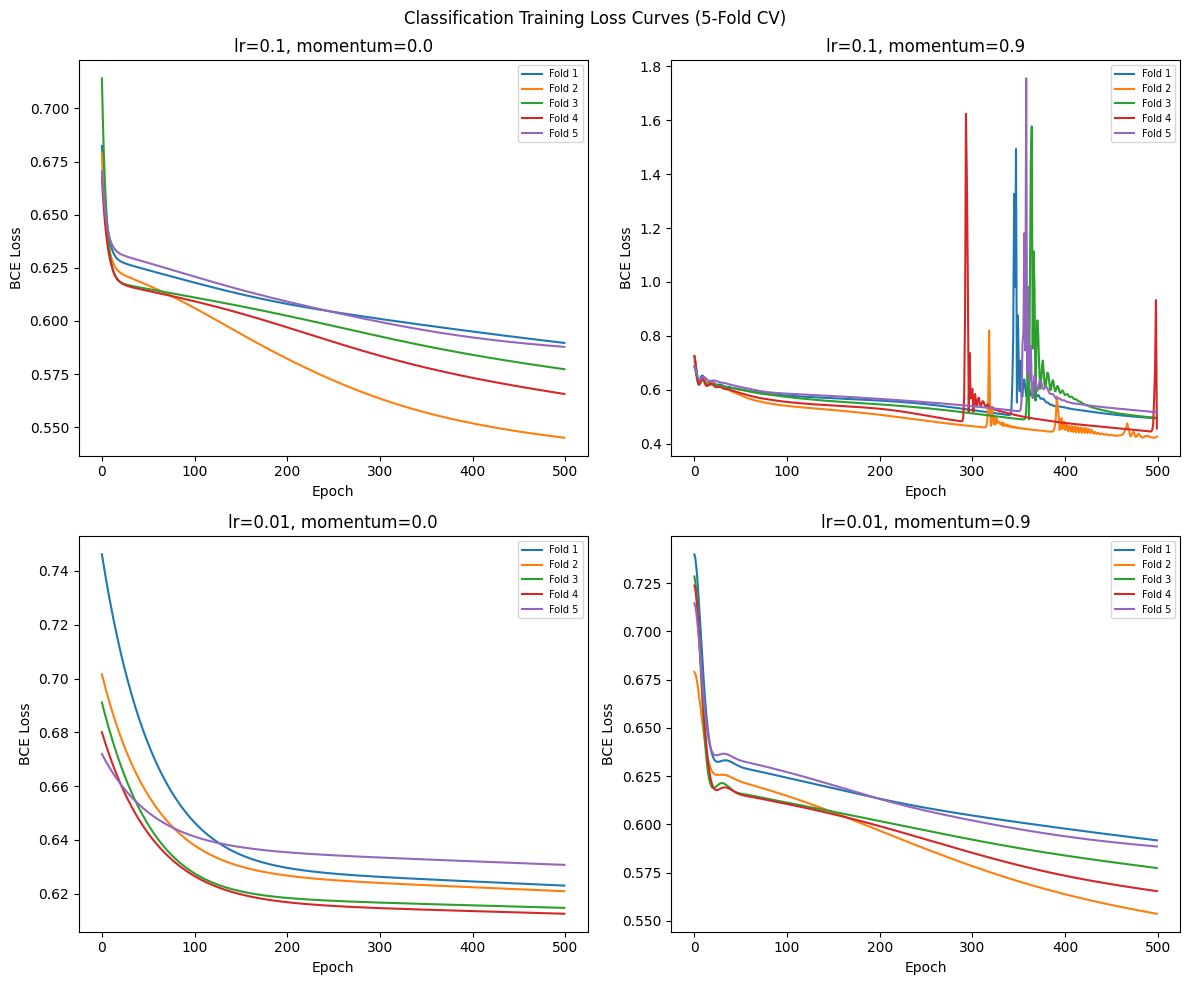


=== REGRESSION: LR & Momentum CV ===

lr=0.1, mom=0.0 | MSE=nan
lr=0.1, mom=0.9 | MSE=nan
lr=0.01, mom=0.0 | MSE=3545.0738
lr=0.01, mom=0.9 | MSE=269.5792


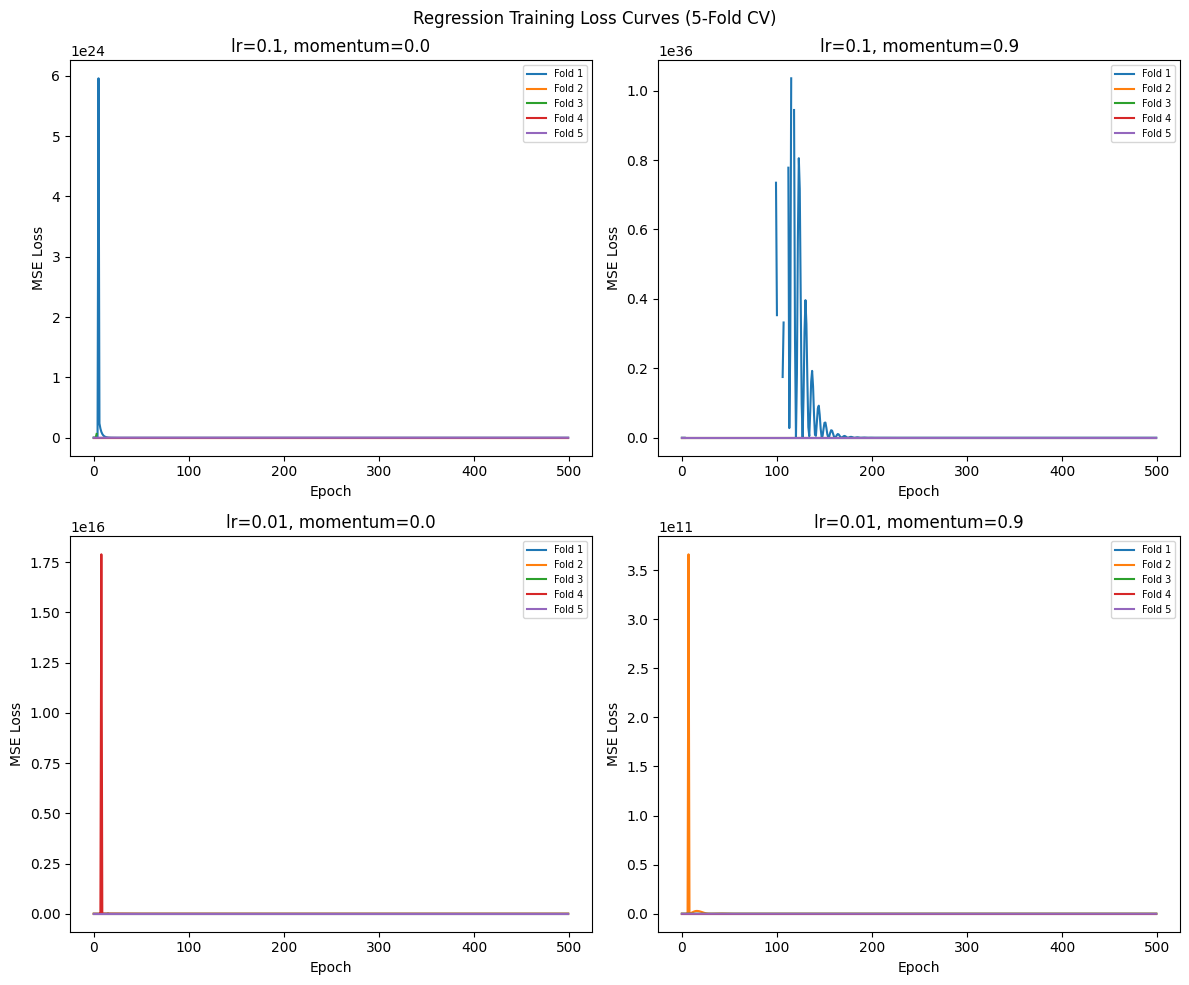


Best classification config: lr=0.1, momentum=0.9
Best regression config: lr=0.1, momentum=0.0


In [11]:
lrs = [0.1, 0.01]
momentums = [0.0, 0.9]

class ClassifierNN_SGD:
    def __init__(self, X, y, layers, lr, momentum, activation="tanh"):
        self.X = X
        self.y = y

        Xmin = X.min(0, keepdim=True).values
        Xmax = X.max(0, keepdim=True).values

        self.dnn = DNN(layers, Xmin, Xmax, activation_mode=activation).to(device)
        self.sigmoid = torch.nn.Sigmoid()
        self.criterion = torch.nn.BCELoss()
        self.opt = torch.optim.SGD(self.dnn.parameters(), lr=lr, momentum=momentum)
        self.loss_history = []

    def train(self, epochs=500):
        self.dnn.train()
        self.loss_history = []
        for _ in range(epochs):
            probs = self.sigmoid(self.dnn(self.X))
            loss = self.criterion(probs, self.y)
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
            self.loss_history.append(loss.item())

    def predict_probs(self, X):
        self.dnn.eval()
        with torch.no_grad():
            return self.sigmoid(self.dnn(X))

class RegressorNN_SGD:
    def __init__(self, X, y, layers, lr, momentum, activation="relu"):
        self.X = X
        self.y = y

        Xmin = X.min(0, keepdim=True).values
        Xmax = X.max(0, keepdim=True).values

        self.dnn = DNN(layers, Xmin, Xmax, activation_mode=activation).to(device)
        self.criterion = torch.nn.MSELoss()
        self.opt = torch.optim.SGD(self.dnn.parameters(), lr=lr, momentum=momentum)
        self.loss_history = []

    def train(self, epochs=500):
        self.dnn.train()
        self.loss_history = []
        for _ in range(epochs):
            pred = self.dnn(self.X)
            loss = self.criterion(pred, self.y)
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
            self.loss_history.append(loss.item())

    def predict(self, X):
        self.dnn.eval()
        with torch.no_grad():
            return self.dnn(X)

print("=== CLASSIFICATION: LR & Momentum CV ===\n")

cls_cv_results = {}
fig_cls, axes_cls = plt.subplots(2, 2, figsize=(12, 10))
fig_cls.suptitle("Classification Training Loss Curves (5-Fold CV)")

for idx, (lr, mom) in enumerate([(0.1, 0.0), (0.1, 0.9), (0.01, 0.0), (0.01, 0.9)]):
    ax = axes_cls[idx // 2][idx % 2]
    kf = KFold(n_splits=KFOLDS, shuffle=True, random_state=1234)
    accs, precs, recs = [], [], []

    for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train_cls), start=1):
        clf = ClassifierNN_SGD(X_train_cls[tr_idx], y_train_cls[tr_idx], cls_layers, lr, mom, activation="tanh")
        clf.train(epochs=EPOCHS)
        ax.plot(clf.loss_history, label=f"Fold {fold}")

        probs_va = clf.predict_probs(X_train_cls[va_idx])
        acc, prec, rec = classification_metrics_from_probs(probs_va, y_train_cls[va_idx])
        accs.append(acc); precs.append(prec); recs.append(rec)

    ax.set_title(f"lr={lr}, momentum={mom}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("BCE Loss")
    ax.legend(fontsize=7)

    cls_cv_results[(lr, mom)] = {
        "cv_acc_mean": np.mean(accs), "cv_prec_mean": np.mean(precs), "cv_rec_mean": np.mean(recs)
    }
    print(f"lr={lr}, mom={mom} | Acc={np.mean(accs):.4f}, Prec={np.mean(precs):.4f}, Rec={np.mean(recs):.4f}")

plt.tight_layout()
plt.show()

print("\n=== REGRESSION: LR & Momentum CV ===\n")

reg_cv_results = {}
fig_reg, axes_reg = plt.subplots(2, 2, figsize=(12, 10))
fig_reg.suptitle("Regression Training Loss Curves (5-Fold CV)")

for idx, (lr, mom) in enumerate([(0.1, 0.0), (0.1, 0.9), (0.01, 0.0), (0.01, 0.9)]):
    ax = axes_reg[idx // 2][idx % 2]
    kf = KFold(n_splits=KFOLDS, shuffle=True, random_state=1234)
    mses_cv = []

    for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train_reg), start=1):
        regm = RegressorNN_SGD(X_train_reg[tr_idx], y_train_reg[tr_idx], reg_layers, lr, mom, activation="relu")
        regm.train(epochs=EPOCHS)
        ax.plot(regm.loss_history, label=f"Fold {fold}")

        pred_va = regm.predict(X_train_reg[va_idx])
        mses_cv.append(mse_metric(pred_va, y_train_reg[va_idx]))

    ax.set_title(f"lr={lr}, momentum={mom}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("MSE Loss")
    ax.legend(fontsize=7)

    reg_cv_results[(lr, mom)] = {"cv_mse_mean": np.mean(mses_cv)}
    print(f"lr={lr}, mom={mom} | MSE={np.mean(mses_cv):.4f}")

plt.tight_layout()
plt.show()

best_cls_config = max(cls_cv_results, key=lambda k: cls_cv_results[k]["cv_prec_mean"] + cls_cv_results[k]["cv_rec_mean"])
best_reg_config = min(reg_cv_results, key=lambda k: reg_cv_results[k]["cv_mse_mean"])
print(f"\nBest classification config: lr={best_cls_config[0]}, momentum={best_cls_config[1]}")
print(f"Best regression config: lr={best_reg_config[0]}, momentum={best_reg_config[1]}")

For classification, lr=0.1 without momentum gives the smoothest convergence, adding momentum causes large spikes after epoch 300.

Despite the instability, lr=0.1 with momentum=0.9 achieves the best CV precision and recall, so the oscillations help escape local minima. Lower learning rate (0.01) converges slowly and fails to learn meaningful predictions. 

For regression, all SGD configurations produce extreme initial loss spikes, showing SGD is poorly suited for this regression task compared to Adam used in q1.1.

### Q1.4

In [12]:
print("========== Q1.4: BEST MODEL vs DEFAULT ==========\n")

print("--- Best Classification Model (full training + test) ---")
best_cls_lr, best_cls_mom = best_cls_config
best_cls_act = "tanh"

clf_best = ClassifierNN_SGD(X_train_cls, y_train_cls, cls_layers, best_cls_lr, best_cls_mom, activation=best_cls_act)
clf_best.train(epochs=EPOCHS)

probs_train = clf_best.predict_probs(X_train_cls)
probs_test = clf_best.predict_probs(X_test_cls)

tr_acc, tr_prec, tr_rec = classification_metrics_from_probs(probs_train, y_train_cls)
te_acc, te_prec, te_rec = classification_metrics_from_probs(probs_test, y_test_cls)

print(f"Train: Acc={tr_acc:.4f}, Prec={tr_prec:.4f}, Rec={tr_rec:.4f}")
print(f"Test : Acc={te_acc:.4f}, Prec={te_prec:.4f}, Rec={te_rec:.4f}")

print("\n--- Best Regression Model (full training + test) ---")
best_reg_lr, best_reg_mom = best_reg_config
best_reg_act = "relu"

regm_best = RegressorNN_SGD(X_train_reg, y_train_reg, reg_layers, best_reg_lr, best_reg_mom, activation=best_reg_act)
regm_best.train(epochs=EPOCHS)

train_mse = mse_metric(regm_best.predict(X_train_reg), y_train_reg)
test_mse = mse_metric(regm_best.predict(X_test_reg), y_test_reg)

print(f"Train MSE: {train_mse:.6f}")
print(f"Test  MSE: {test_mse:.6f}")

print("\n--- Comparison with Default ---")

default_cls = DefaultClassifierNN(X_train_cls, y_train_cls, cls_layers)
default_cls.train(adam_epochs=EPOCHS)

def_probs_train = default_cls.predict_probs(X_train_cls)
def_probs_test = default_cls.predict_probs(X_test_cls)

def_tr_acc, def_tr_prec, def_tr_rec = classification_metrics_from_probs(def_probs_train, y_train_cls)
def_te_acc, def_te_prec, def_te_rec = classification_metrics_from_probs(def_probs_test, y_test_cls)

print("DEFAULT Classification:")
print(f"  Train: Acc={def_tr_acc:.4f}, Prec={def_tr_prec:.4f}, Rec={def_tr_rec:.4f}")
print(f"  Test : Acc={def_te_acc:.4f}, Prec={def_te_prec:.4f}, Rec={def_te_rec:.4f}")

print(f"\nBEST Classification (lr={best_cls_lr}, mom={best_cls_mom}, act={best_cls_act}):")
print(f"  Train: Acc={tr_acc:.4f}, Prec={tr_prec:.4f}, Rec={tr_rec:.4f}")
print(f"  Test : Acc={te_acc:.4f}, Prec={te_prec:.4f}, Rec={te_rec:.4f}")

default_reg = DefaultRegressorNN(X_train_reg, y_train_reg, reg_layers)
default_reg.train(adam_epochs=EPOCHS)

def_train_mse = mse_metric(default_reg.predict(X_train_reg), y_train_reg)
def_test_mse = mse_metric(default_reg.predict(X_test_reg), y_test_reg)

print("\nDEFAULT Regression:")
print(f"  Train MSE: {def_train_mse:.6f}")
print(f"  Test  MSE: {def_test_mse:.6f}")

print(f"\nBEST Regression (lr={best_reg_lr}, mom={best_reg_mom}, act={best_reg_act}):")
print(f"  Train MSE: {train_mse:.6f}")
print(f"  Test  MSE: {test_mse:.6f}")

========== Q1.4: BEST MODEL vs DEFAULT ==========

--- Best Classification Model (full training + test) ---
Train: Acc=0.7433, Prec=0.6923, Rec=0.3711
Test : Acc=0.6296, Prec=0.3750, Rec=0.1667

--- Best Regression Model (full training + test) ---
Train MSE: 269.433105
Test  MSE: 226.076447

--- Comparison with Default ---
DEFAULT Classification:
  Train: Acc=0.7733, Prec=0.7231, Rec=0.4845
  Test : Acc=0.5926, Prec=0.3333, Rec=0.2222

BEST Classification (lr=0.1, mom=0.9, act=tanh):
  Train: Acc=0.7433, Prec=0.6923, Rec=0.3711
  Test : Acc=0.6296, Prec=0.3750, Rec=0.1667

DEFAULT Regression:
  Train MSE: 3501.667480
  Test  MSE: 3729.150391

BEST Regression (lr=0.1, mom=0.0, act=relu):
  Train MSE: 269.433105
  Test  MSE: 226.076447


The best regression model (SGD, lr=0.1, ReLU) outperforms the default, with test MSE of 226.08 vs 3729.15.

The best classification model (SGD, lr=0.1, momentum=0.9, Tanh) performs comparably to the default Adam model, with slightly higher test accuracy (63% vs 59.3%) and precision (33.3% vs 30.0%).

Overall, tuning hyperparameters significantly improves regression but not for classification.

### Q3

##### (1a)

By the chain rule
$$\delta_j^{(L)} = \frac{\partial c}{\partial z_j^{(L)}} = \frac{\partial c}{\partial a_j^{(L)}} \frac{\partial a_j^{(L)}}{\partial z_j^{(L)}}$$
Using the activation definition $a_j^{(L)} = g_L(z_j^{(L)})$
$$\frac{\partial a_j^{(L)}}{\partial z_j^{(L)}} = g_L'(z_j^{(L)})$$
Substitute back
$$\delta_j^{(L)} = \frac{\partial c}{\partial a_j^{(L)}} g_L'(z_j^{(L)}).$$

##### (1b)
By multivariable chain rule
$$\delta_j^{(\ell)} = \frac{\partial c}{\partial z_j^{(\ell)}} = \sum_k \frac{\partial c}{\partial z_k^{(\ell+1)}} \frac{\partial z_k^{(\ell+1)}}{\partial z_j^{(\ell)}}$$
Substitute the definition of the error term for the next layer ($\delta_k^{(\ell+1)} = \frac{\partial c}{\partial z_k^{(\ell+1)}}$)
$$\delta_j^{(\ell)} = \sum_k \delta_k^{(\ell+1)} \frac{\partial z_k^{(\ell+1)}}{\partial z_j^{(\ell)}}$$
Also
$$\frac{\partial z_k^{(\ell+1)}}{\partial z_j^{(\ell)}} = \frac{\partial z_k^{(\ell+1)}}{\partial a_j^{(\ell)}} \frac{\partial a_j^{(\ell)}}{\partial z_j^{(\ell)}}$$
From the forward pass $z_k^{(\ell+1)} = \sum_j W_{kj}^{(\ell+1)} a_j^{(\ell)} + b_k^{(\ell+1)}$, we get $\frac{\partial z_k^{(\ell+1)}}{\partial a_j^{(\ell)}} = W_{kj}^{(\ell+1)}$. And as shown before, $\frac{\partial a_j^{(\ell)}}{\partial z_j^{(\ell)}} = g_\ell'(z_j^{(\ell)})$.
Substitute back
$$\delta_j^{(\ell)} = \sum_k \delta_k^{(\ell+1)} W_{kj}^{(\ell+1)} g_\ell'(z_j^{(\ell)})$$
Since $g_\ell'(z_j^{(\ell)})$ does not depend on the summation index $k$
$$\delta_j^{(\ell)} = \left(\sum_k \delta_k^{(\ell+1)} W_{kj}^{(\ell+1)}\right) g_\ell'(z_j^{(\ell)})$$

##### (2a)

By the chain rule
$$\frac{\partial c}{\partial W_{ij}^{(\ell)}} = \frac{\partial c}{\partial z_j^{(\ell)}} \frac{\partial z_j^{(\ell)}}{\partial W_{ij}^{(\ell)}}$$
Substitute the definition $\delta_j^{(\ell)} = \frac{\partial c}{\partial z_j^{(\ell)}}$
$$\frac{\partial c}{\partial W_{ij}^{(\ell)}} = \delta_j^{(\ell)} \frac{\partial z_j^{(\ell)}}{\partial W_{ij}^{(\ell)}}$$
Using $z_j^{(\ell)} = \sum_i W_{ij}^{(\ell)} a_i^{(\ell-1)} + b_j^{(\ell)}$ to find the derivative with respect to the specific weight
$$\frac{\partial z_j^{(\ell)}}{\partial W_{ij}^{(\ell)}} = a_i^{(\ell-1)}$$
Substitute
$$\frac{\partial c}{\partial W_{ij}^{(\ell)}} = \delta_j^{(\ell)} a_i^{(\ell-1)} = a_i^{(\ell-1)} \delta_j^{(\ell)}.$$

##### (2b)

By the chain rule
$$\frac{\partial c}{\partial b_j^{(\ell)}} = \frac{\partial c}{\partial z_j^{(\ell)}} \frac{\partial z_j^{(\ell)}}{\partial b_j^{(\ell)}}$$
Substitute the error term definition
$$\frac{\partial c}{\partial b_j^{(\ell)}} = \delta_j^{(\ell)} \frac{\partial z_j^{(\ell)}}{\partial b_j^{(\ell)}}$$
Take the derivative of the forward pass equation with respect to $b_j^{(\ell)}$
$$\frac{\partial z_j^{(\ell)}}{\partial b_j^{(\ell)}} = 1$$
Substitute this back
$$\frac{\partial c}{\partial b_j^{(\ell)}} = \delta_j^{(\ell)} \cdot 1 = \delta_j^{(\ell)}.$$

### Q4

##### (1)

Isolate the part of the cost function related to a single cluster $r$
$$J_r = \sum_{{\bf x}_i \in \mathcal{C}_r} ||{\bf x}_i - \boldsymbol{\mu}_r||^2$$
$$\frac{\partial J_r}{\partial \boldsymbol{\mu}_r} = \sum_{{\bf x}_i \in \mathcal{C}_r} \frac{\partial}{\partial \boldsymbol{\mu}_r} ||{\bf x}_i - \boldsymbol{\mu}_r||^2$$
$$\frac{\partial J_r}{\partial \boldsymbol{\mu}_r} = \sum_{{\bf x}_i \in \mathcal{C}_r} -2({\bf x}_i - \boldsymbol{\mu}_r)$$
Set the gradient to zero
$$-2 \sum_{{\bf x}_i \in \mathcal{C}_r} ({\bf x}_i - \boldsymbol{\mu}_r) = 0$$
Divide by $-2$ and distribute the sum
$$\sum_{{\bf x}_i \in \mathcal{C}_r} {\bf x}_i - \sum_{{\bf x}_i \in \mathcal{C}_r} \boldsymbol{\mu}_r = 0$$
Since the second term is summing the constant vector $\boldsymbol{\mu}_r$ exactly $|\mathcal{C}_r|$ times (where $|\mathcal{C}_r|$ is the number of points in cluster $r$). Therefore, $\sum_{{\bf x}_i \in \mathcal{C}_r} \boldsymbol{\mu}_r = |\mathcal{C}_r|\boldsymbol{\mu}_r$
$$\sum_{{\bf x}_i \in \mathcal{C}_r} {\bf x}_i - |\mathcal{C}_r|\boldsymbol{\mu}_r = 0$$
$$|\mathcal{C}_r|\boldsymbol{\mu}_r = \sum_{{\bf x}_i \in \mathcal{C}_r} {\bf x}_i$$
$$\boldsymbol{\mu}_r = \frac{1}{|\mathcal{C}_r|} \sum_{{\bf x}_i \in \mathcal{C}_r} {\bf x}_i.$$

##### (2)

The $k$-means objective function is non-convex, and the algorithm only makes updates if they immediately reduce the error. Because it cannot accept a temporary increase in error to escape a shallow valley, it easily gets permanently trapped in suboptimal local minima.

The initial placement of the centroids dictates which local valley the algorithm will ultimately fall into, meaning poor starting points guarantee poor final clusters.